In [41]:
import pandas as pd
import numpy as np
import os
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy
from IPython.display import display, HTML
from typing import List, Callable, Dict
from nltk.corpus import stopwords
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD

In [14]:
pd.set_option('display.max_rows',10)

#### Import Data

In [15]:
data = pd.read_csv('/Users/dylanhayashi/Desktop/Northwestern/MSDS_453_Public/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv')

#### Data Wrangling

In [16]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [17]:
def nlp_transformations(df):
    """
    Apply NLP transformations to a pandas DataFrame.
    Parameters: df (DataFrame): Input dataframe with a column named 'Text'.
    Returns: DataFrame: A new dataframe with added columns for each NLP transformation.
    """
    df['Tokens'] = df['Text'].apply(word_tokenize)
    df['Normalized'] = df['Tokens'].apply(lambda x: [word.lower() for word in x])
    df['Lemmatized'] = df['Normalized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    df['No_Stop_Words'] = df['Lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])
    df['Cleaned'] = df['No_Stop_Words'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', word) for word in x])
    df['Cleaned'] = df['Cleaned'].apply(lambda x: [word for word in x if word != ''])
    df['wrangle_one'] = df['Normalized']
    df['wrangle_two'] = df['No_Stop_Words']
    df['wrangle_three'] = df['Cleaned']
    return df

In [18]:
wrangled_data = nlp_transformations(data).sort_values('Genre of Movie')
wrangled_data

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Tokens,Normalized,Lemmatized,No_Stop_Words,Cleaned,wrangle_one,wrangle_two,wrangle_three
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Negative,Taxi,"[Jimmy, Fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, s, big, screen, career, may, e...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, s, big, screen, career, may, e..."
116,46,KCM_Doc7_AngelHasFallen,Authorities take Secret Service agent Mike Ban...,KCM_Doc7_AngelHasFallen,KCM,Action,Positive,Angel Has Fallen,"[Authorities, take, Secret, Service, agent, Mi...","[authorities, take, secret, service, agent, mi...","[authority, take, secret, service, agent, mike...","[authority, take, secret, service, agent, mike...","[authority, take, secret, service, agent, mike...","[authorities, take, secret, service, agent, mi...","[authority, take, secret, service, agent, mike...","[authority, take, secret, service, agent, mike..."
115,45,KCM_Doc6_AngelHasFallen,American movie presidents can only make us wis...,KCM_Doc6_AngelHasFallen,KCM,Action,Positive,Angel Has Fallen,"[American, movie, presidents, can, only, make,...","[american, movie, presidents, can, only, make,...","[american, movie, president, can, only, make, ...","[american, movie, president, make, u, wistful,...","[american, movie, president, make, u, wistful,...","[american, movie, presidents, can, only, make,...","[american, movie, president, make, u, wistful,...","[american, movie, president, make, u, wistful,..."
114,44,KCM_Doc5_AngelHasFallen,"No, you dont need to have seen Olympus Has F...",KCM_Doc5_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[No, ,, you, dont, need, to, have, seen, Oly...","[no, ,, you, dont, need, to, have, seen, oly...","[no, ,, you, dont, need, to, have, seen, oly...","[,, dont, need, seen, olympus, ha, fallen, ...","[dont, need, seen, olympus, ha, fallen, andor,...","[no, ,, you, dont, need, to, have, seen, oly...","[,, dont, need, seen, olympus, ha, fallen, ...","[dont, need, seen, olympus, ha, fallen, andor,..."
113,43,KCM_Doc4_AngelHasFallen,There is a certain mindless pleasure in the Fa...,KCM_Doc4_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[There, is, a, certain, mindless, pleasure, in...","[there, is, a, certain, mindless, pleasure, in...","[there, is, a, certain, mindless, pleasure, in...","[certain, mindless, pleasure, fallen, movie, ....","[certain, mindless, pleasure, fallen, movie, w...","[there, is, a, certain, mindless, pleasure, in...","[certain, mindless, pleasure, fallen, movie, ....","[certain, mindless, pleasure, fallen, movie, w..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,54,JTG_Doc5_Oblivion,What do you need for the ultimate Tom Cruise v...,JTG_Doc5_Oblivion,JTG,Sci-Fi,Negative,Oblivion,"[What, do, you, need, for, the, ultimate, Tom,...","[what, do, you, need, for, the, ultimate, tom,...","[what, do, you, need, for, the, ultimate, tom,...","[need, ultimate, tom, cruise, vehicle, ?, vehi...","[need, ultimate, tom, cruise, vehicle, vehicle...","[what, do, you, need, for, the, ultimate, tom,...","[need, ultimate, tom, cruise, vehicle, ?, vehi...","[need, ultimate, tom, cruise, vehicle, vehicle..."
133,53,JTG_Doc4_Oblivion,"In Oblivion, Tom Cruise plays a post-apocaly...",JTG_Doc4_Oblivion,JTG,Sci-Fi,Negative,Oblivion,"[In, Oblivion, ,, , Tom, Cruise, plays, a, p...","[in, oblivion, ,, , tom, cruise, plays, a, p...","[in, oblivion, ,, , tom, cruise, play, a, po...","[oblivion, ,, , tom, cruise, play, post-apoc...","[oblivion, tom, cruise, play, postapocalyptic,...","[in, oblivion, ,, , tom, cruise, plays, a, p...","

#### Create visualization legend dictionaries

In [ ]:
unique_titles = wrangled_data['Movie Title'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_titles)))
color_map = dict(zip(unique_titles, colors))

unique_genres = wrangled_data['Genre of Movie'].unique()
markers = ['o', 's', '^', 'D']  # Example: circle, square, triangle, diamond
if len(markers) < len(unique_genres):
    raise ValueError("Please provide at least as many marker shapes as there are unique genres.")
marker_map = dict(zip(unique_genres, markers))

#### Part 1: Clustering via tf-idf or Doc2Vec

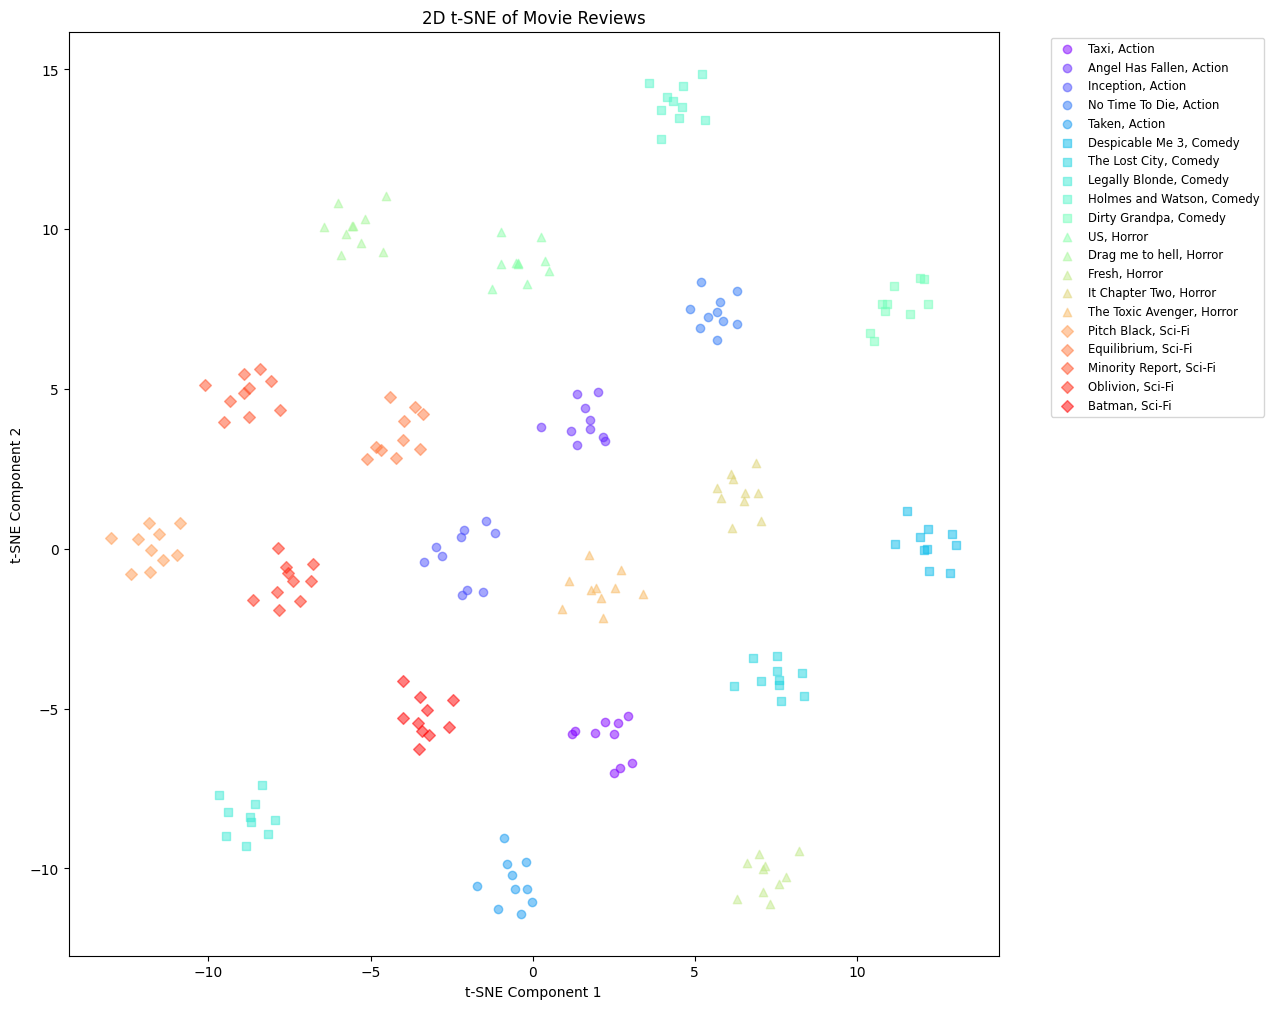

In [47]:
vectorizer = TfidfVectorizer()  # Consider limiting features for simplicity and efficacy
X_tfidf = vectorizer.fit_transform(wrangled_data['wrangle_three'].apply(' '.join))

# Model Fitting
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
model_knn.fit(X_tfidf)

# Finding Neighbors (excluding the point itself)
distances, indices = model_knn.kneighbors(X_tfidf, n_neighbors=11)


# Dimensionality Reduction
X_embedded = TSNE(n_components=2,init='random').fit_transform(X_tfidf)

plt.figure(figsize=(12, 12))

# Loop through each title-genre combination and plot with corresponding color and marker
for title in unique_titles:
    for genre in unique_genres:
        mask = (wrangled_data['Movie Title'] == title) & (wrangled_data['Genre of Movie'] == genre)
        if mask.sum() == 0:  # Skip if there are no matching records
            continue
        
        plt.scatter(
            X_embedded[mask, 0], X_embedded[mask, 1],
            color=color_map[title], marker=marker_map[genre],
            alpha=0.5, label=f"{title}, {genre}"
        )

# Place a legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE of Movie Reviews')
plt.show()


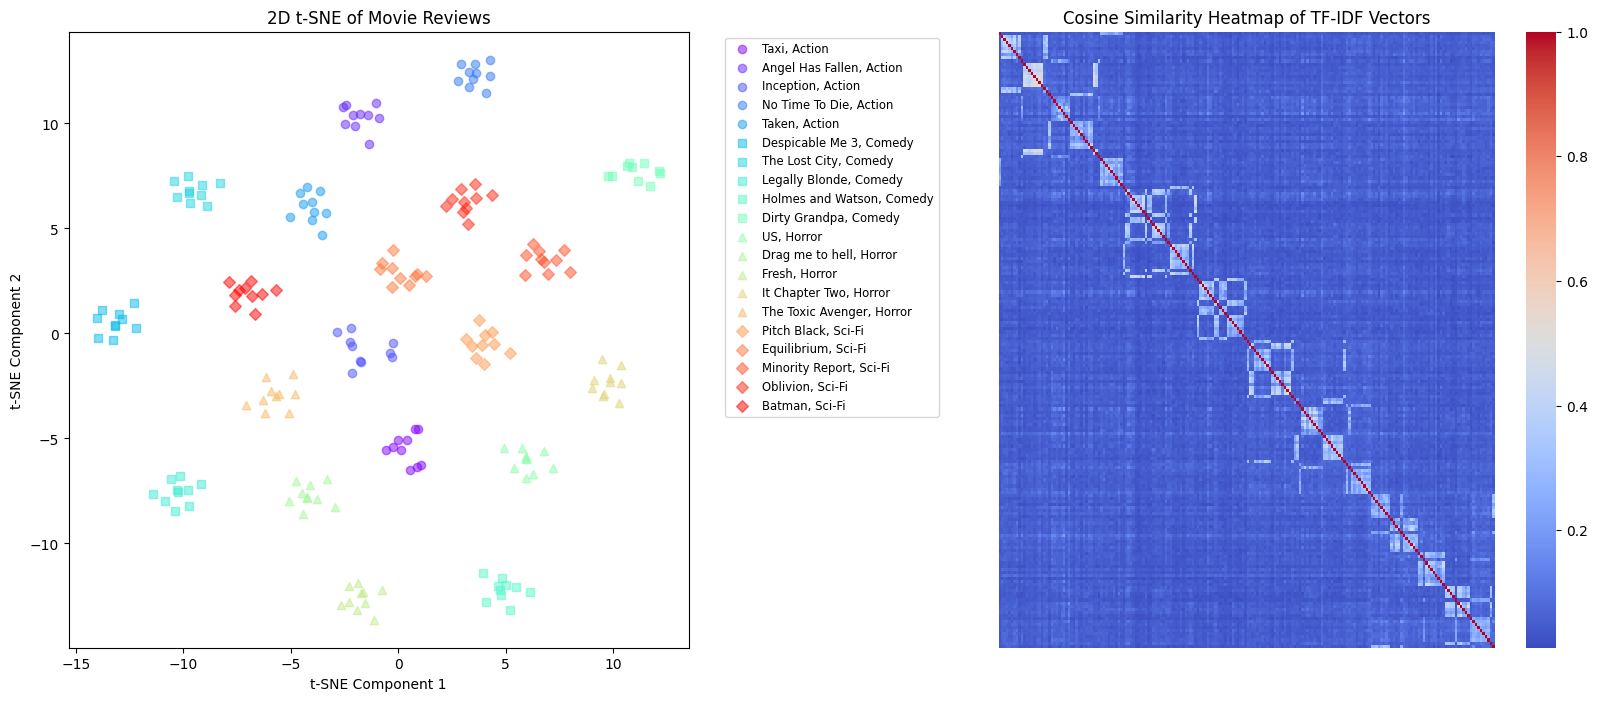

In [51]:

# Assume `wrangled_data`, `unique_titles`, and `unique_genres` are predefined
# Assume `color_map` and `marker_map` are predefined

# Vectorization
vectorizer = TfidfVectorizer()  # Consider limiting features
X_tfidf = vectorizer.fit_transform(wrangled_data['wrangle_three'].apply(' '.join))

# Model Fitting
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
model_knn.fit(X_tfidf)

# Finding Neighbors (excluding the point itself)
distances, indices = model_knn.kneighbors(X_tfidf, n_neighbors=11)

# Dimensionality Reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_tfidf)

# Cosine Similarity
cosine_sim = cosine_similarity(X_tfidf)

# Creating Subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns
plt.subplots_adjust(wspace=0.5) # you can adjust this value to manage the space

# t-SNE Visualization
ax = axs[0]

for title in unique_titles:
    for genre in unique_genres:
        mask = (wrangled_data['Movie Title'] == title) & (wrangled_data['Genre of Movie'] == genre)
        if mask.sum() == 0:
            continue
        
        ax.scatter(
            X_embedded[mask, 0], X_embedded[mask, 1],
            color=color_map[title], marker=marker_map[genre],
            alpha=0.5, label=f"{title}, {genre}"
        )

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE of Movie Reviews')

# Cosine Similarity Heatmap
ax = axs[1]

sns.heatmap(cosine_sim, ax=ax, cmap='coolwarm', xticklabels=False, yticklabels=False)
ax.set_title('Cosine Similarity Heatmap of TF-IDF Vectors')
plt.show()


#### Part 2: Clustering via LDA/LDI

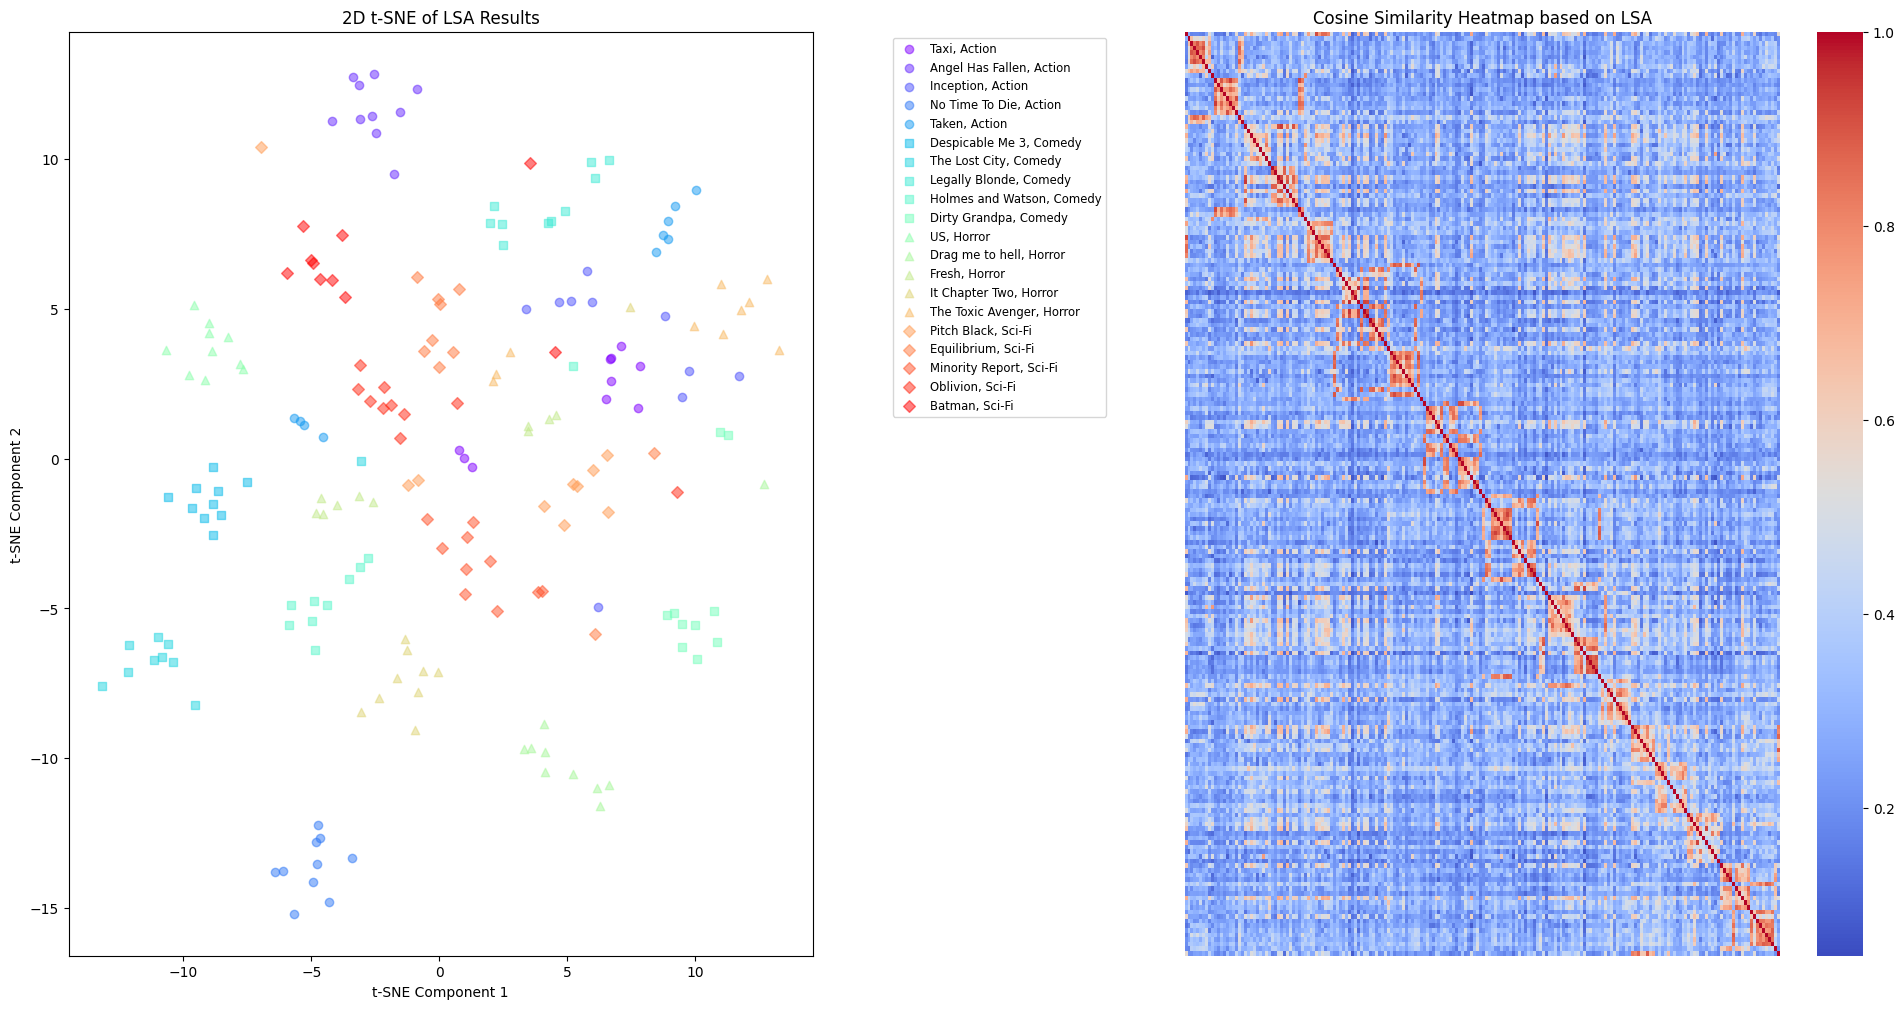

In [52]:


# Assuming wrangled_data, unique_titles, and unique_genres are defined
# Define color_map and marker_map here

# Convert tokenized words into a document-term matrix
def dummy(doc):
    return doc

vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=5000)
X_count = vectorizer.fit_transform(wrangled_data['wrangle_three'])

# Fit LSA model using TruncatedSVD
lsa = TruncatedSVD(n_components=50, random_state=42)  # using 50 components to capture more variance
X_lsa = lsa.fit_transform(X_count)

# t-SNE for Dimensionality Reduction on LSA results
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_lsa)

# Cosine Similarity based on LSA results
cosine_sim = cosine_similarity(X_lsa)

# Creating Subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
plt.subplots_adjust(wspace=0.5) # adjust space between plots

# 1st subplot: t-SNE Visualization
ax = axs[0]

for title in unique_titles:
    for genre in unique_genres:
        mask = (wrangled_data['Movie Title'] == title) & (wrangled_data['Genre of Movie'] == genre)
        if mask.sum() == 0:
            continue
        
        ax.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            color=color_map[title], marker=marker_map[genre],
            alpha=0.5, label=f"{title}, {genre}"
        )

ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize='small')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE of LSA Results')

# 2nd subplot: Cosine Similarity Heatmap
ax = axs[1]
sns.heatmap(cosine_sim, ax=ax, cmap='coolwarm', xticklabels=False, yticklabels=False)
ax.set_title('Cosine Similarity Heatmap based on LSA')

plt.show()


#### Text Vectorization using tf-idf

In [30]:
def get_top_n_words(tfidf_vector, feature_names, n=10):
    # Calculate mean tfidf frequency of each term through documents
    means = tfidf_vector.mean(axis=0)

    # Connecting term to its mean frequency
    data = []
    for col, term in enumerate(feature_names):
        data.append((term, means[0, col]))

    ranking = pd.DataFrame(data, columns=['term', 'mean_tfidf'])
    ranking = ranking.sort_values('mean_tfidf', ascending=False)
    
    return pd.DataFrame(ranking.head(n)).reset_index(drop=True).round(4)

In [31]:
corpus_one = []
for document in wrangled_data.loc[:,'wrangle_one']:
    for token in document:
        corpus_one.append(token)

corpus_two = []
for document in wrangled_data.loc[:,'wrangle_two']:
    for token in document:
        corpus_two.append(token)

corpus_three = []
for document in wrangled_data.loc[:,'wrangle_three']:
    for token in document:
        corpus_three.append(token)

tfidf_vectorizer_one = TfidfVectorizer()
tfidf_vectorizer_two = TfidfVectorizer()
tfidf_vectorizer_three = TfidfVectorizer()

tfidf_one = tfidf_vectorizer_one.fit_transform(corpus_one)
tfidf_two = tfidf_vectorizer_two.fit_transform(corpus_two)
tfidf_three = tfidf_vectorizer_three.fit_transform(corpus_three)

feature_names_one = tfidf_vectorizer_one.get_feature_names_out()
feature_names_two = tfidf_vectorizer_two.get_feature_names_out()
feature_names_three = tfidf_vectorizer_three.get_feature_names_out()

top_words_one = get_top_n_words(tfidf_one, feature_names_one, 50)
top_words_two = get_top_n_words(tfidf_two, feature_names_two, 50)
top_words_three = get_top_n_words(tfidf_three, feature_names_three, 50)

result = pd.concat([top_words_one, top_words_two, top_words_three], axis=1, keys=['Wrangle One', 'Wrangle Two', 'Wrangle Three'])
pd.DataFrame(result)

Wrangle One            Wrangle Two            Wrangle Three           
          term mean_tfidf        term mean_tfidf          term mean_tfidf
0          the     0.0483        film     0.0085          film     0.0103
1          and     0.0241       movie     0.0069         movie     0.0085
2           of     0.0233          ha     0.0057            ha     0.0071
3           to     0.0225         one     0.0052           one     0.0063
4           in     0.0148          wa     0.0048            wa     0.0060
5           is     0.0143        like     0.0042          like     0.0051
6         that     0.0114        time     0.0036          time     0.0045
7           it     0.0111         get     0.0031           get     0.0038
8           as     0.0078        make     0.0030          make     0.0037
9         with     0.0078   character     0.0028            nt     0.0035
10         for     0.0067        even     0.0027     character     0.0034
11         but     0.0061       scene     0.0025          even     0.0033
12         his     0.0061         doe     0.0023         scene     0.0031
13          he     0.0054        much     0.0023           doe     0.0028
14        this     0.0052         way     0.0022          much     0.0028
15          on     0.0050       would     0.0022           way     0.0027
16        film     0.0045      action     0.0021         would     0.0027
17         are     0.0042        also     0.0020          also     0.0025
18          be     0.0041       thing     0.0020        action     0.0025
19          an     0.0040       first     0.0019         thing     0.0025
20          by     0.0038        come     0.0019          come     0.0024
21         you     0.0038        take     0.0019           its     0.0024
22         not     0.0037       story     0.0018         first     0.0023
23         her     0.0035        good     0.0018          take     0.0023
24         has     0.0035         see     0.0017         story     0.0023
25          at     0.0034          go     0.0017          good     0.0022
26       movie     0.0033        well     0.0017           see     0.0022
27        from     0.0033        year     0.0017            go     0.0022
28         who     0.0033         two     0.0017          year     0.0021
29        have     0.0032        bond     0.0016           two     0.0021
30         one     0.0031        look     0.0016          well     0.0021
31         was     0.0030         new     0.0016          bond     0.0020
32         all     0.0029      people     0.0015          look     0.0020
33       there     0.0026        work     0.0015           new     0.0020
34         out     0.0025          it     0.0015        people     0.0019
35        like     0.0025       never     0.0015          work     0.0019
36        when     0.0024       world     0.0015         never     0.0018
37          or     0.0024        best     0.0014          best     0.0018
38          so     0.0024       could     0.0014         could     0.0017
39        more     0.0024      horror     0.0013         world     0.0017
40        they     0.0024      little     0.0013        little     0.0016
41          up     0.0024   something     0.0013     something     0.0016
42        what     0.0023        know     0.0013          know     0.0016
43         she     0.0022        feel     0.0013          feel     0.0016
44       their     0.0022        many     0.0013          many     0.0016
45       about     0.0021        back     0.0013        horror     0.0016
46       which     0.0020         set     0.0013          find     0.0016
47        into     0.0020        find     0.0012          back     0.0016
48         can     0.0020        life     0.0012           say     0.0016
49          if     0.0020         say     0.0012        though     0.0015

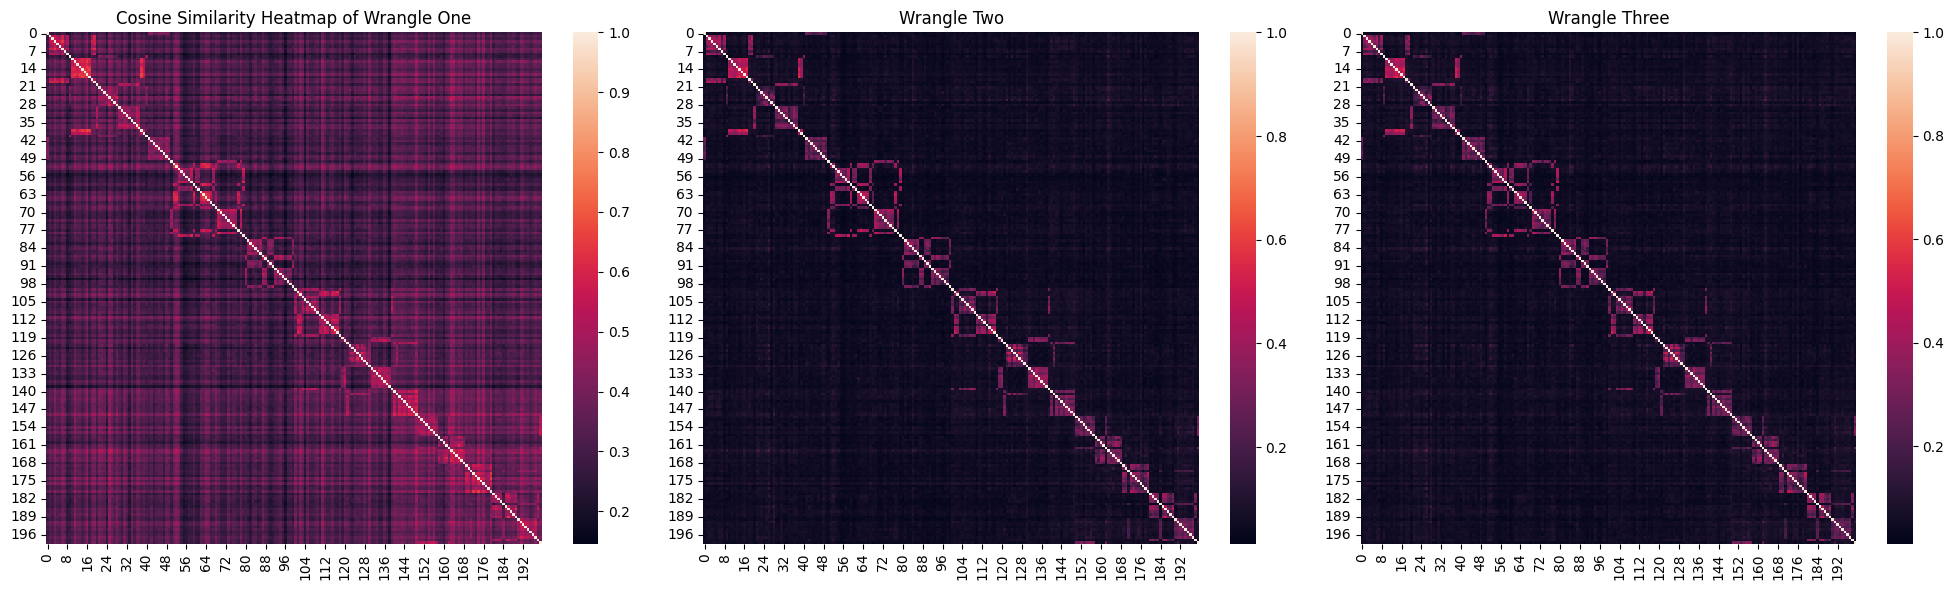

In [32]:
wrangled_data['tfidf_one'] = wrangled_data['wrangle_one'].apply(' '.join)
wrangled_data['tfidf_two'] = wrangled_data['wrangle_two'].apply(' '.join)
wrangled_data['tfidf_three'] = wrangled_data['wrangle_three'].apply(' '.join)

vectorizer_one = TfidfVectorizer()
vectorizer_two = TfidfVectorizer()
vectorizer_three = TfidfVectorizer()

tfidf_matrix_one = vectorizer_one.fit_transform(wrangled_data['tfidf_one'])
tfidf_matrix_two = vectorizer_two.fit_transform(wrangled_data['tfidf_two'])
tfidf_matrix_three = vectorizer_three.fit_transform(wrangled_data['tfidf_three'])

cosine_sim_one = cosine_similarity(tfidf_matrix_one)
cosine_sim_two = cosine_similarity(tfidf_matrix_two)
cosine_sim_three = cosine_similarity(tfidf_matrix_three)

fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.heatmap(cosine_sim_one,ax=axs[0])
axs[0].set_title('Cosine Similarity Heatmap of Wrangle One')
sns.heatmap(cosine_sim_two,ax=axs[1])
axs[1].set_title('Wrangle Two')
sns.heatmap(cosine_sim_three,ax=axs[2])
axs[2].set_title('Wrangle Three')

plt.tight_layout()
plt.show()

#### Text Vectorization using Word2Vec

In [33]:
tokens = top_words_three.loc[0:100, 'term'].tolist()

corpus_one = [document for document in wrangled_data.loc[:, 'wrangle_one']]
corpus_two = [document for document in wrangled_data.loc[:, 'wrangle_two']]
corpus_three = [document for document in wrangled_data.loc[:, 'wrangle_three']]

model_one = Word2Vec(corpus_one, vector_size=100, window=5, min_count=1, workers=4)
model_two = Word2Vec(corpus_one, vector_size=200, window=5, min_count=1, workers=4)
model_three = Word2Vec(corpus_one, vector_size=300, window=5, min_count=1, workers=4)
model_four = Word2Vec(corpus_two, vector_size=100, window=5, min_count=1, workers=4)
model_five = Word2Vec(corpus_two, vector_size=200, window=5, min_count=1, workers=4)
model_six = Word2Vec(corpus_two, vector_size=300, window=5, min_count=1, workers=4)
model_seven = Word2Vec(corpus_three, vector_size=100, window=5, min_count=1, workers=4)
model_eight = Word2Vec(corpus_three, vector_size=200, window=5, min_count=1, workers=4)
model_nine = Word2Vec(corpus_three, vector_size=300, window=5, min_count=1, workers=4)

tokens_one = [token for token in tokens if token in model_one.wv.key_to_index]
tokens_two = [token for token in tokens if token in model_two.wv.key_to_index]
tokens_three = [token for token in tokens if token in model_three.wv.key_to_index]
tokens_four = [token for token in tokens if token in model_four.wv.key_to_index]
tokens_five = [token for token in tokens if token in model_five.wv.key_to_index]
tokens_six = [token for token in tokens if token in model_six.wv.key_to_index]
tokens_seven = [token for token in tokens if token in model_seven.wv.key_to_index]
tokens_eight = [token for token in tokens if token in model_eight.wv.key_to_index]
tokens_nine = [token for token in tokens if token in model_nine.wv.key_to_index]

vectors_one = np.array([model_one.wv[token] for token in tokens_one])
vectors_two = np.array([model_two.wv[token] for token in tokens_two])
vectors_three = np.array([model_three.wv[token] for token in tokens_three])
vectors_four = np.array([model_four.wv[token] for token in tokens_four])
vectors_five = np.array([model_five.wv[token] for token in tokens_five])
vectors_six = np.array([model_six.wv[token] for token in tokens_six])
vectors_seven = np.array([model_seven.wv[token] for token in tokens_seven])
vectors_eight = np.array([model_eight.wv[token] for token in tokens_eight])
vectors_nine = np.array([model_nine.wv[token] for token in tokens_nine])

vector_sets = [vectors_one, vectors_two, vectors_three, vectors_four, vectors_five, vectors_six, vectors_seven, vectors_eight, vectors_nine]
token_sets = [tokens_one, tokens_two, tokens_three, tokens_four, tokens_five, tokens_six, tokens_seven, tokens_eight, tokens_nine]

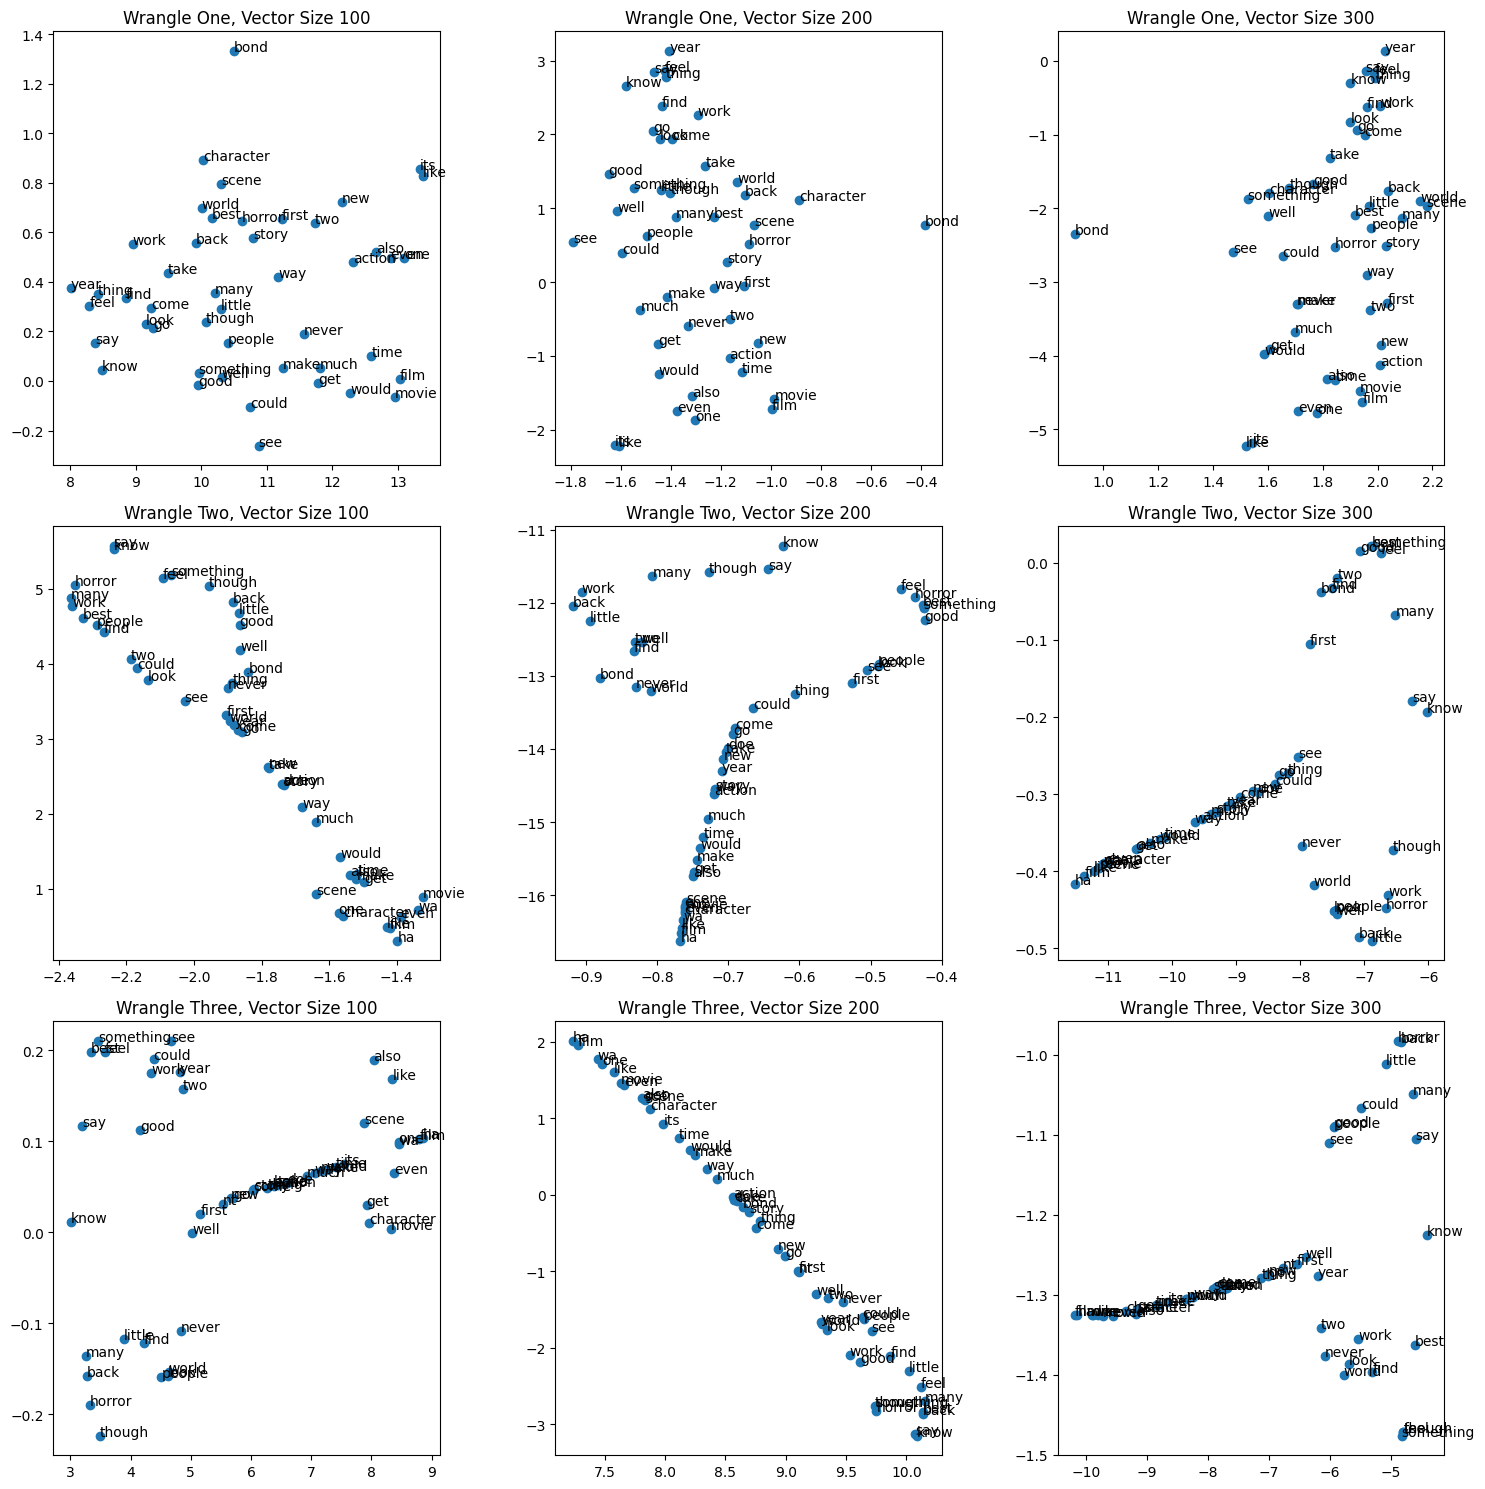

In [34]:
# Create a subplot of 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten axes for easy iteration
flat_axes = axes.flatten()

# Assuming you have 9 sets of results to plot
for ax, tokens, vectors in zip(flat_axes, token_sets, vector_sets):
    tsne_results = TSNE(n_components=2).fit_transform(vectors)
    ax.scatter(tsne_results[:, 0], tsne_results[:, 1])
    for i, token in enumerate(tokens):
        ax.annotate(token, (tsne_results[i, 0], tsne_results[i, 1]))

axes[0,0].set_title('Wrangle One, Vector Size 100')
axes[0,1].set_title('Wrangle One, Vector Size 200')
axes[0,2].set_title('Wrangle One, Vector Size 300')
axes[1,0].set_title('Wrangle Two, Vector Size 100')
axes[1,1].set_title('Wrangle Two, Vector Size 200')
axes[1,2].set_title('Wrangle Two, Vector Size 300')
axes[2,0].set_title('Wrangle Three, Vector Size 100')
axes[2,1].set_title('Wrangle Three, Vector Size 200')
axes[2,2].set_title('Wrangle Three, Vector Size 300')

# Adjust spacing
plt.tight_layout()
plt.show()

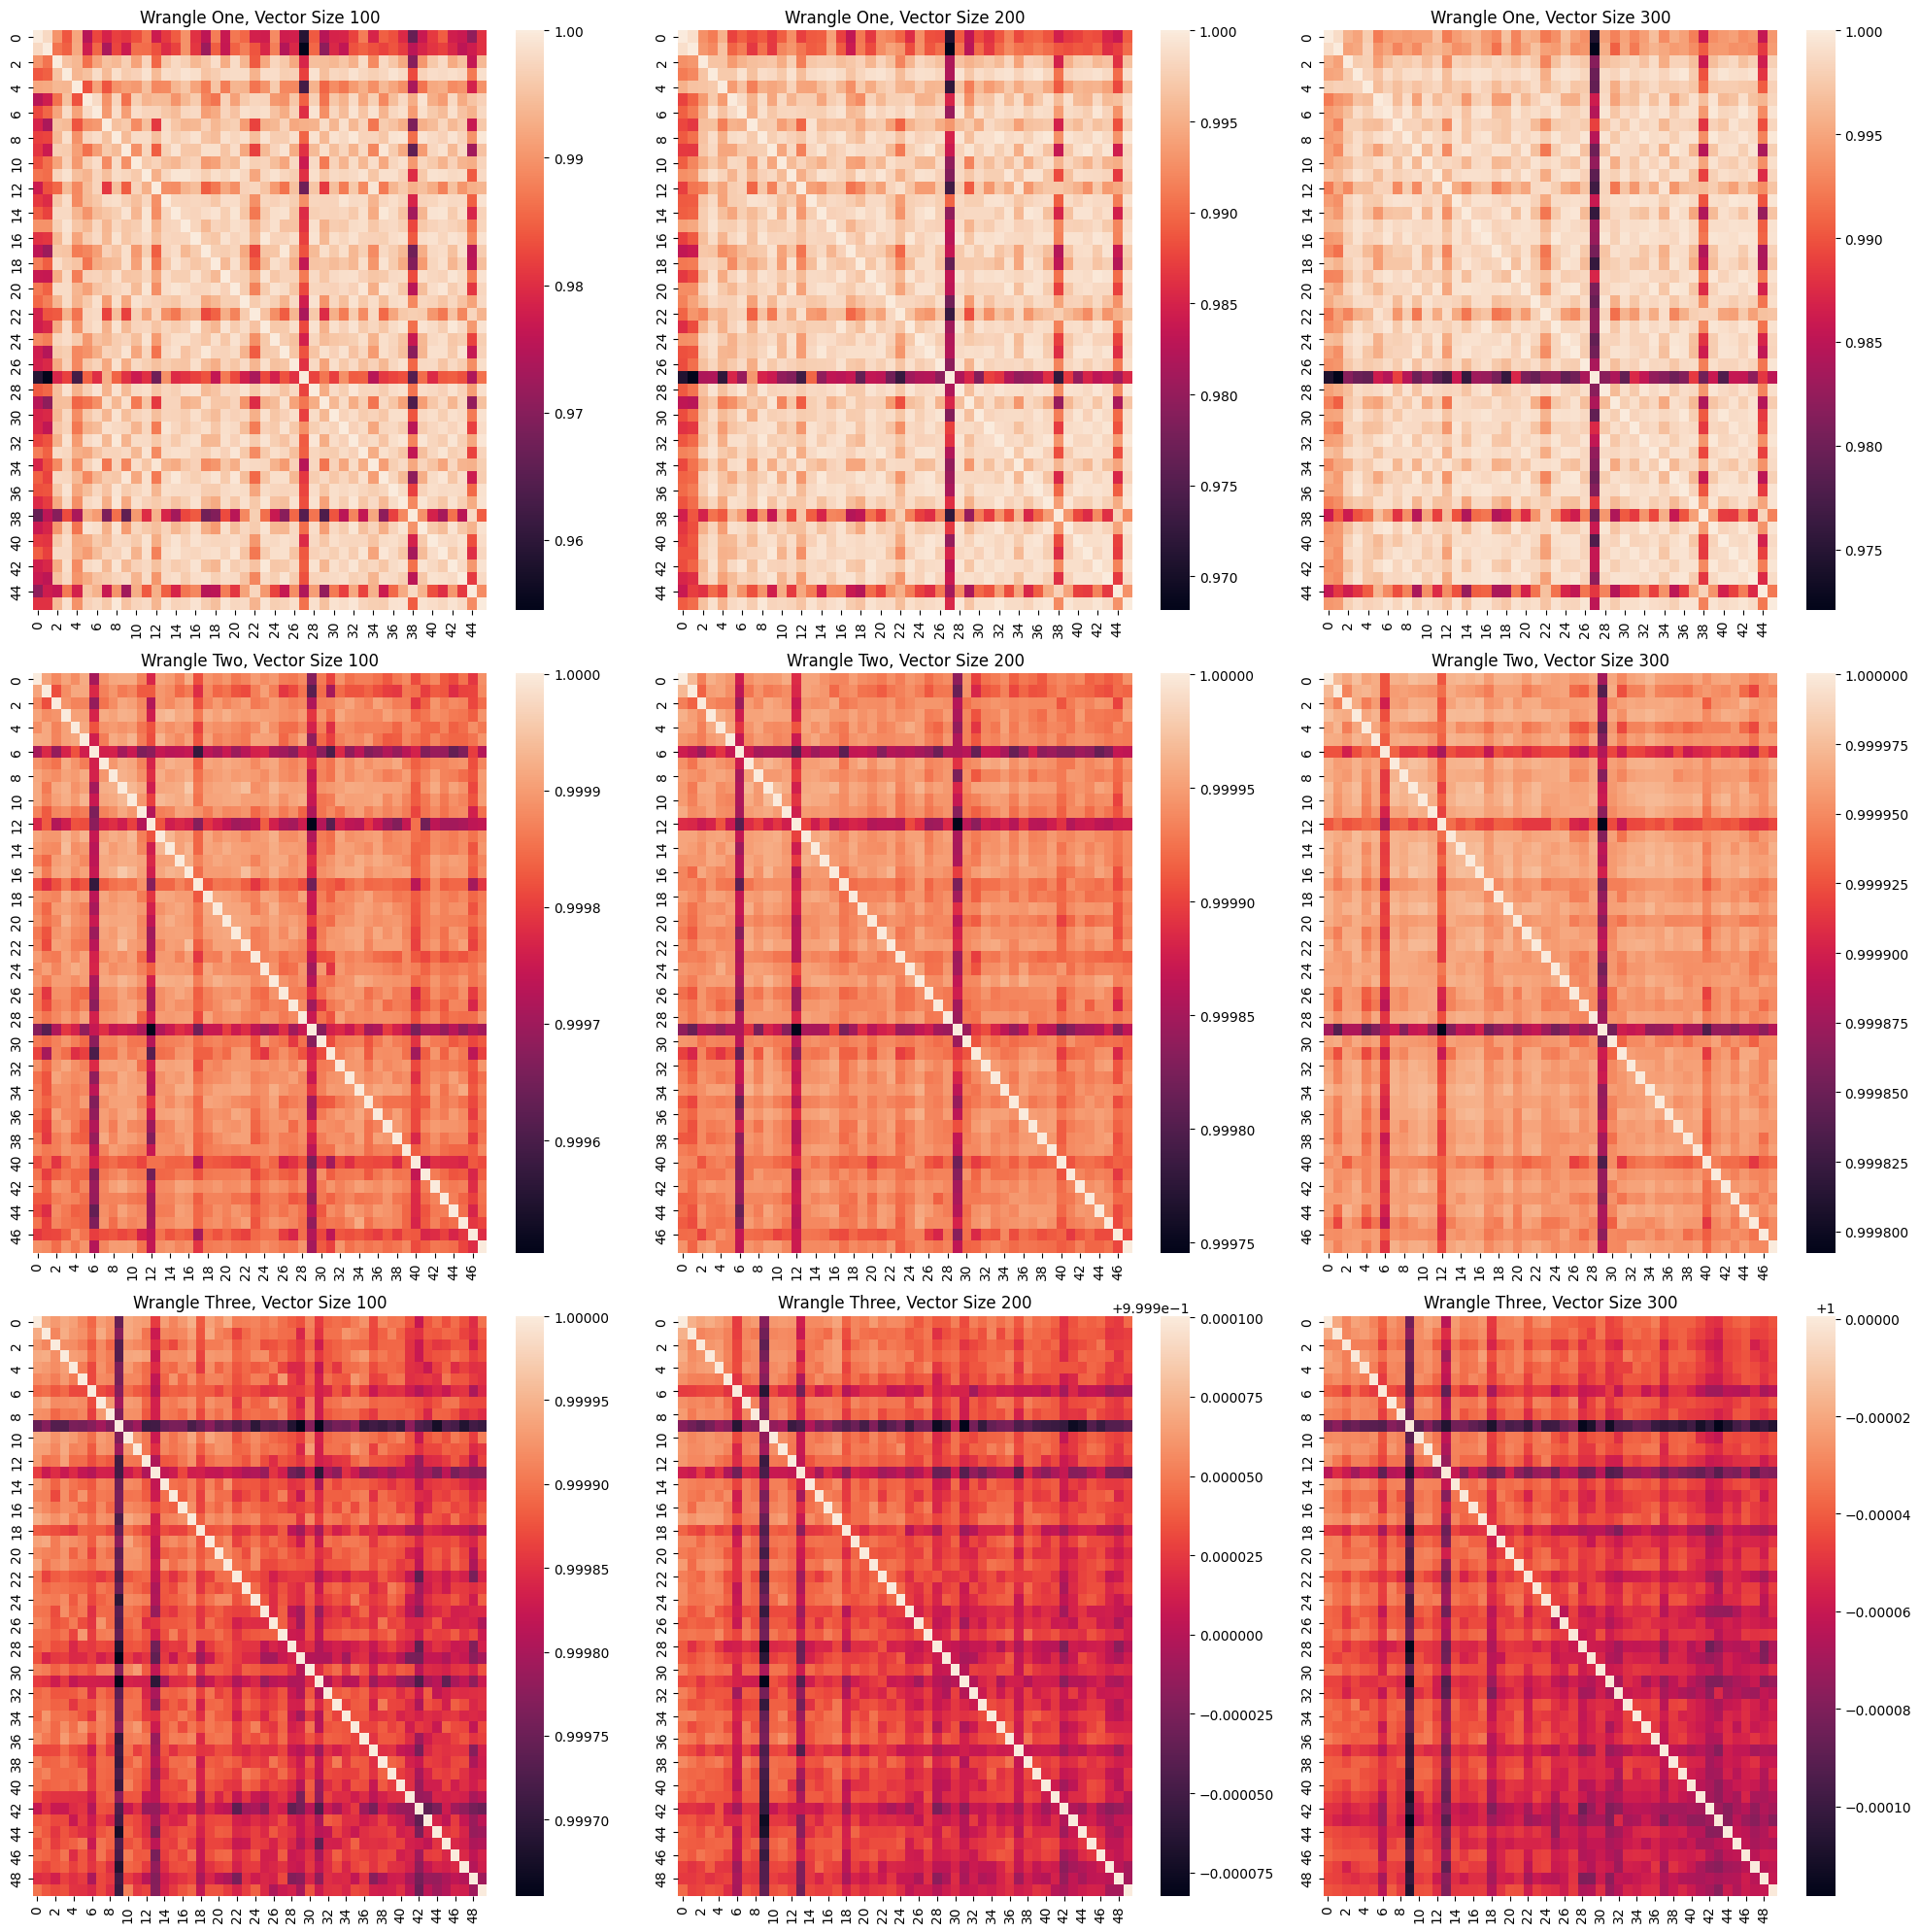

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  # Adjust the size as per your need
flat_axes = axes.flatten()

for ax, tokens, vectors in zip(flat_axes, token_sets, vector_sets):
    cos_sim_matrix = cosine_similarity(vectors)
    sns.heatmap(cos_sim_matrix, annot=False, ax=ax)

axes[0,0].set_title('Wrangle One, Vector Size 100')
axes[0,1].set_title('Wrangle One, Vector Size 200')
axes[0,2].set_title('Wrangle One, Vector Size 300')
axes[1,0].set_title('Wrangle Two, Vector Size 100')
axes[1,1].set_title('Wrangle Two, Vector Size 200')
axes[1,2].set_title('Wrangle Two, Vector Size 300')
axes[2,0].set_title('Wrangle Three, Vector Size 100')
axes[2,1].set_title('Wrangle Three, Vector Size 200')
axes[2,2].set_title('Wrangle Three, Vector Size 300')
    
plt.tight_layout()
plt.show()

#### Text Vectorization using Doc2Vec

In [36]:
tokens = top_words_three.loc[0:100, 'term'].tolist()

In [37]:
corpus_one = []
for i, document in enumerate(wrangled_data.loc[:,'wrangle_one']):
    doc = TaggedDocument(words=document,tags=f'Doc{i}')
    corpus_one.append(doc)

corpus_two = []
for i, document in enumerate(wrangled_data.loc[:,'wrangle_two']):
    doc = TaggedDocument(words=document,tags=f'Doc{i}')
    corpus_two.append(doc)

corpus_three = []
for i, document in enumerate(wrangled_data.loc[:,'wrangle_three']):
    doc = TaggedDocument(words=document,tags=f'Doc{i}')
    corpus_three.append(doc)

model_one = Doc2Vec(corpus_one, vector_size=100, window=5, min_count=2, workers=12)
model_two = Doc2Vec(corpus_one, vector_size=200, window=5, min_count=2, workers=12)
model_three = Doc2Vec(corpus_one, vector_size=300, window=5, min_count=2, workers=12)
model_four = Doc2Vec(corpus_two, vector_size=100, window=5, min_count=2, workers=12)
model_five = Doc2Vec(corpus_two, vector_size=200, window=5, min_count=2, workers=12)
model_six = Doc2Vec(corpus_two, vector_size=300, window=5, min_count=2, workers=12)
model_seven = Doc2Vec(corpus_three, vector_size=100, window=5, min_count=2, workers=12)
model_eight = Doc2Vec(corpus_three, vector_size=200, window=5, min_count=2, workers=12)
model_nine = Doc2Vec(corpus_three, vector_size=300, window=5, min_count=2, workers=12)

doc_vectors_one = [model_one.infer_vector(doc.words) for doc in corpus_one]
doc_vectors_two = [model_two.infer_vector(doc.words) for doc in corpus_one]
doc_vectors_three = [model_three.infer_vector(doc.words) for doc in corpus_one]
doc_vectors_four = [model_four.infer_vector(doc.words) for doc in corpus_two]
doc_vectors_five = [model_five.infer_vector(doc.words) for doc in corpus_two]
doc_vectors_six = [model_six.infer_vector(doc.words) for doc in corpus_two]
doc_vectors_seven = [model_seven.infer_vector(doc.words) for doc in corpus_three]
doc_vectors_eight = [model_eight.infer_vector(doc.words) for doc in corpus_three]
doc_vectors_nine = [model_nine.infer_vector(doc.words) for doc in corpus_three]

cosine_similarity_matrix_one = 1 - pairwise_distances(doc_vectors_one, metric="cosine")
cosine_similarity_matrix_two = 1 - pairwise_distances(doc_vectors_two, metric="cosine")
cosine_similarity_matrix_three = 1 - pairwise_distances(doc_vectors_three, metric="cosine")
cosine_similarity_matrix_four = 1 - pairwise_distances(doc_vectors_four, metric="cosine")
cosine_similarity_matrix_five = 1 - pairwise_distances(doc_vectors_five, metric="cosine")
cosine_similarity_matrix_six = 1 - pairwise_distances(doc_vectors_six, metric="cosine")
cosine_similarity_matrix_seven = 1 - pairwise_distances(doc_vectors_seven, metric="cosine")
cosine_similarity_matrix_eight = 1 - pairwise_distances(doc_vectors_eight, metric="cosine")
cosine_similarity_matrix_nine = 1 - pairwise_distances(doc_vectors_nine, metric="cosine")

In [38]:
doc_vectors_sets = [doc_vectors_one,doc_vectors_two,doc_vectors_three,doc_vectors_four,doc_vectors_five,doc_vectors_six,doc_vectors_seven,doc_vectors_eight,doc_vectors_nine]
cosine_similarity_matrix_sets = [cosine_similarity_matrix_one,cosine_similarity_matrix_two,cosine_similarity_matrix_three,cosine_similarity_matrix_four,cosine_similarity_matrix_five,cosine_similarity_matrix_six,cosine_similarity_matrix_seven,cosine_similarity_matrix_eight,cosine_similarity_matrix_nine]

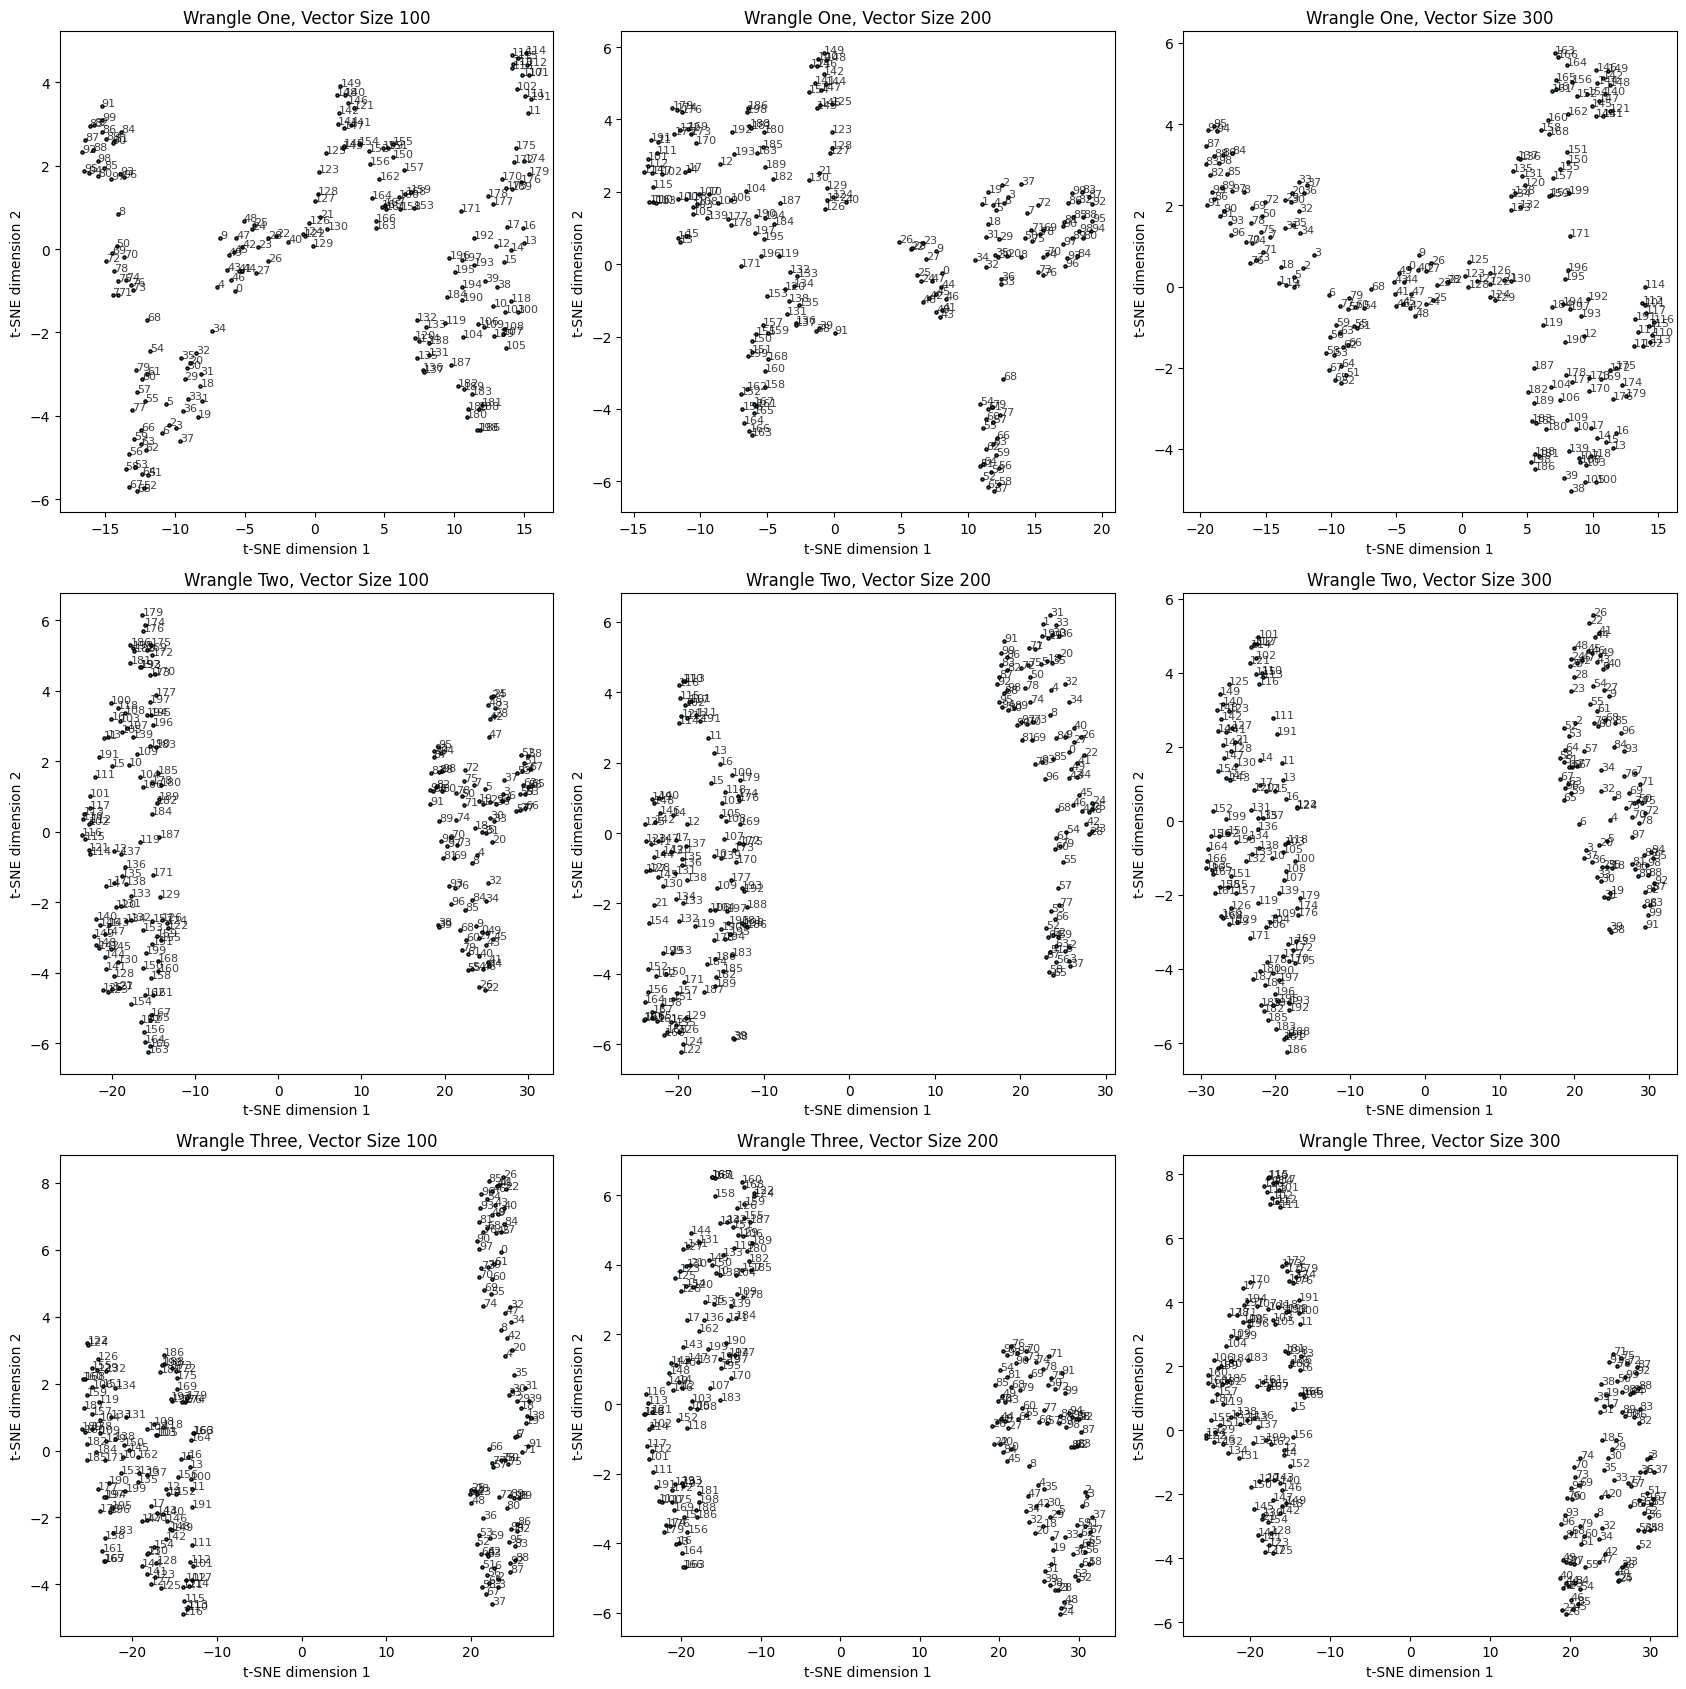

In [50]:
# Apply t-SNE to reduce vectors to 2 dimensions
tsne = TSNE(n_components=2, random_state=0)

reduced_vectors_one = tsne.fit_transform(np.array(doc_vectors_one))
reduced_vectors_two = tsne.fit_transform(np.array(doc_vectors_two))
reduced_vectors_three = tsne.fit_transform(np.array(doc_vectors_three))
reduced_vectors_four = tsne.fit_transform(np.array(doc_vectors_four))
reduced_vectors_five = tsne.fit_transform(np.array(doc_vectors_five))
reduced_vectors_six = tsne.fit_transform(np.array(doc_vectors_six))
reduced_vectors_seven = tsne.fit_transform(np.array(doc_vectors_seven))
reduced_vectors_eight = tsne.fit_transform(np.array(doc_vectors_eight))
reduced_vectors_nine = tsne.fit_transform(np.array(doc_vectors_nine))

all_vector_sets = [reduced_vectors_one,reduced_vectors_two,reduced_vectors_three,reduced_vectors_four,reduced_vectors_five,reduced_vectors_six,reduced_vectors_seven,reduced_vectors_eight,reduced_vectors_nine]

# Initialize a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(17, 17))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA07A', '#8A2BE2', '#7FFF00']


# Loop through all the vector sets and plot them in subplots
for i, vectors in enumerate(all_vector_sets):
    reduced_vectors = tsne.fit_transform(np.array(vectors))
    
    # Determine subplot row and column
    row = i // 3
    col = i % 3
    
    # Scatter plot in the determined subplot
    axs[row, col].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', s=5, edgecolor='k')
    
    # Optionally, annotate points with document ids or titles
    for j, vec in enumerate(reduced_vectors):
        axs[row, col].annotate(str(j), (vec[0], vec[1]), fontsize=8, alpha=0.75)

axs[0,0].set_title('Wrangle One, Vector Size 100')
axs[0,1].set_title('Wrangle One, Vector Size 200')
axs[0,2].set_title('Wrangle One, Vector Size 300')
axs[1,0].set_title('Wrangle Two, Vector Size 100')
axs[1,1].set_title('Wrangle Two, Vector Size 200')
axs[1,2].set_title('Wrangle Two, Vector Size 300')
axs[2,0].set_title('Wrangle Three, Vector Size 100')
axs[2,1].set_title('Wrangle Three, Vector Size 200')
axs[2,2].set_title('Wrangle Three, Vector Size 300')


# Set labels and adjust layout
for ax in axs.flat:
    ax.set(xlabel='t-SNE dimension 1', ylabel='t-SNE dimension 2')
plt.tight_layout()
plt.show()

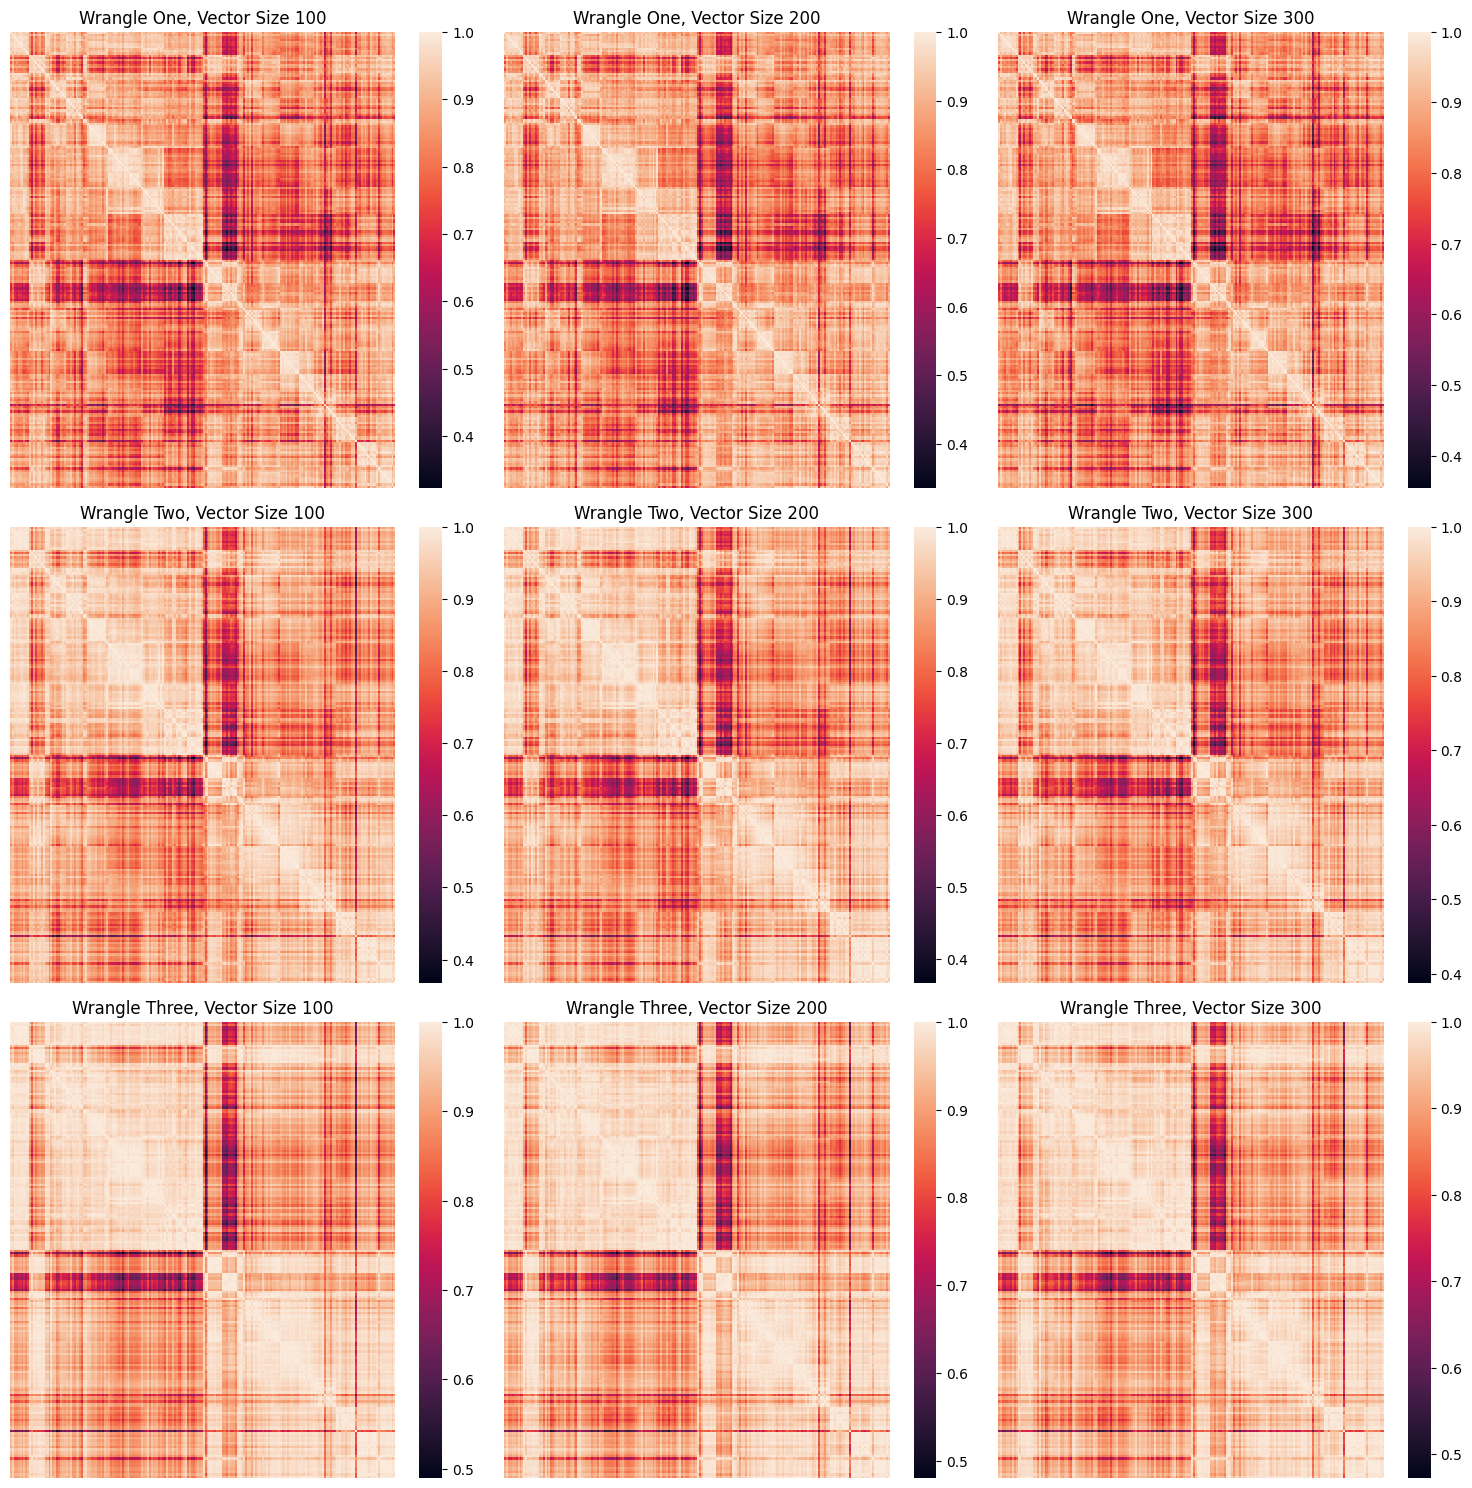

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjust the size as per your requirement

for i, matrix in enumerate(cosine_similarity_matrix_sets):
    row = i // 3  # Integer division gives us the row number
    col = i % 3   # Remainder gives us the column number
    
    # Create a heatmap in the (row, col) subplot
    sns.heatmap(matrix, annot=False, ax=axs[row, col], cbar=True, xticklabels=False, yticklabels=False)

axs[0,0].set_title('Wrangle One, Vector Size 100')
axs[0,1].set_title('Wrangle One, Vector Size 200')
axs[0,2].set_title('Wrangle One, Vector Size 300')
axs[1,0].set_title('Wrangle Two, Vector Size 100')
axs[1,1].set_title('Wrangle Two, Vector Size 200')
axs[1,2].set_title('Wrangle Two, Vector Size 300')
axs[2,0].set_title('Wrangle Three, Vector Size 100')
axs[2,1].set_title('Wrangle Three, Vector Size 200')
axs[2,2].set_title('Wrangle Three, Vector Size 300')

plt.tight_layout()  # Adjusts subplot params for better layout
plt.show()